In [ ]:
!nvidia-smi

Mon Jun 20 17:53:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data Preparation

In [ ]:
# For Colab only!
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os

In [ ]:
all_data = []
if os.getcwd().split("\\")[len(os.getcwd().split("\\")) - 1] != "data":
    os.chdir('/content/drive/MyDrive/BA/data')

for f in os.listdir():
    # print(f)
    part_id = f.split("_")[1].split(".")[0]
    # print(part_id)
    df = pd.read_csv(f, sep=";")
    df["part_id"] = part_id
    all_data.append(df)

## Normalize by Screensize

In [ ]:
import copy

In [ ]:
def normalize_by_screen(datapoint, screenwidth, screenheight):
    normalized = copy.deepcopy(datapoint)
    normalized["xPos"] /= screenwidth
    normalized["TargetX"] /= screenwidth
    normalized["StartX"] /= screenwidth
    normalized["TunnelAmplitude"] /= screenwidth
    normalized["yPos"] /= screenheight
    normalized["TunnelWidth"] /= screenheight
    normalized["YDistanceToTop"] /= screenheight
    normalized["YDistanceToBottom"] /= screenheight
    return normalized

In [ ]:
def get_participants_screensize(datapoint):
    x_res = -1
    y_res = -1
    # print(datapoint)
    curr_part_id = datapoint["part_id"][0]
    # print(part_id)
    for f in os.listdir():
        curr_id = f.split("_")[1].split(".")[0]
        if curr_id == curr_part_id:
            demographic = pd.read_csv(f, sep=";")
            real_res_string = demographic["Real Res"][0]
            real_res_string = real_res_string.replace("px", "")
            x_res = real_res_string.split(" x ")[0]
            y_res = real_res_string.split(" x ")[1]
    return int(x_res), int(y_res)

In [ ]:
def normalize_screensize(dataset):
    if os.getcwd().split("\\")[len(os.getcwd().split("\\")) - 1] != "demographic_data":
        os.chdir("/content/drive/MyDrive/BA/demographic_data")
    for i, datapoint in enumerate(dataset):
        screenwidth, screenheight = get_participants_screensize(datapoint)
        dataset[i] = normalize_by_screen(datapoint, screenwidth, screenheight)

## First Order Derivation

In [ ]:
def get_data_with_derivate(datapoint):
    diffSeries = datapoint["xPos"].diff(periods=1)
    datapoint.insert(3, "xSpeed", diffSeries)
    diffSeries = datapoint["yPos"].diff(periods=1)
    datapoint.insert(5, "ySpeed", diffSeries)

## To np Array

In [ ]:
import numpy as np

In [ ]:
def get_np_arrays(data):
    data_array = []
    for curr in data:
        removed = copy.deepcopy(curr)
        removed = removed.drop('timestamp', axis=1)
        removed = removed.drop('xPos', axis=1)
        removed = removed.drop('yPos', axis=1)
        removed = removed.drop('part_id', axis=1)
        data_array.append(removed.to_numpy(copy=True))
    return data_array

## Split into sections

In [ ]:
def append_samples_of_length_n(participant_data, n, samples, labels, label_distance):
    for i in range(participant_data.shape[0] - (n+label_distance)):
        samples.append(copy.deepcopy(participant_data[i:i+n]))
        sum_to_label = np.array([0,0], dtype='float64')
        for j in range (i+n, i+n+label_distance):
            sum_to_label += participant_data[j][1:3]
        labels.append(copy.deepcopy(sum_to_label))
        # labels.append(copy.deepcopy(participant_data[i+n+label_distance][1:3]))

In [ ]:
def get_samples_and_labels(data_array, N=10, label_distance=10):
    samples = []
    labels = []
    for participant_data in data_array:
        append_samples_of_length_n(participant_data, N, samples, labels, label_distance)
    return samples, labels

## Remove unusable

In [ ]:
def remove_unusable(data, labels, verbose=0):
    # print(labels)
    new_data = []
    new_labels = []
    for i, sample in enumerate(data):
        bool_array = np.all(sample == sample[0,:], axis=0)
        if bool_array[1] == False or bool_array[2] == False:
            if labels[i][0] != 0:
                new_data.append(sample)
                new_labels.append(labels[i])
        if verbose > 1 and i % 100000 == 0:
            print(f'evaluated {i}')

    if verbose > 0:
        print(f'removed {len(data) - len(new_data)} samples')

    return new_data, new_labels

## Make face the same way

In [ ]:
def make_same_orientation(data, labels, verbose=0):
    changed = 0
    for i, sample in enumerate(data):
        average_x_speed = np.average(sample, axis=0)[1]
        if average_x_speed < 0:
            # print(sample[:, 1])
            sample[:, 1] *= -1
            # print(labels[i])
            # print(labels[i][0])
            labels[i][0] *= -1
            if verbose > 0:
                changed += 1
    if verbose > 0:
        print(f'Changed {changed} samples')

## Total transformation

In [ ]:
def get_transformed_data(dataset, N, label_distance, verbose):
    normalize_screensize(dataset)

    if'xSpeed' not in dataset[0].columns:
        for datapoint in dataset:
            get_data_with_derivate(datapoint)
            datapoint.drop(index=0, axis=0, inplace=True)

    data_array = get_np_arrays(dataset)

    samples, labels = get_samples_and_labels(data_array, N, label_distance)

    samples, labels = remove_unusable(samples, labels, verbose=verbose)

    make_same_orientation(samples, labels, verbose=verbose)

    return samples, labels

## Train-Test-Split

In [ ]:
TRAIN_SPLIT = 0.8
TEST_SPLIT = 1.0 - TRAIN_SPLIT

In [ ]:
import random as rand
SEED = 27255

In [ ]:
def get_train_test_split_data(dataset):
    train_data_amount = 0.8 * len(dataset)

    train_data = []
    test_data = []

    rand.seed(SEED)
    train_indizes = rand.sample(range(len(dataset)), int(train_data_amount))
    # print(train_indizes)

    for i, sample in enumerate(dataset):
        if i in train_indizes:
            train_data.append(sample)
        else:
            test_data.append(sample)

    # print(len(train_data))
    # print(len(test_data))

    return train_data, test_data

## Normalize

In [ ]:
def get_average_array(arr, axis=(0,1)):
    return np.mean(arr, axis=axis)

In [ ]:
def get_normalized_arrays(train_samples, train_labels, test_samples, test_labels):
    #avg_array = get_average_array(train_samples)
    # print(avg_array)
    #avg_label_array = get_average_array(train_labels, 0)

    train_array = np.array(train_samples)
    test_array = np.array(test_samples)
    train_labels_array = np.array(train_labels)
    test_labels_array = np.array(test_labels)

    #train_normalized = train_array[:, :, ] / avg_array
    #train_normalized[:, : , 0] = train_array[:, :, 0]
    #train_normalized[:, :, 2] = train_array[:, :, 2]

    #test_normalized = test_array[:, :, ] / avg_array
    #test_normalized[:, :, 0] = test_array[:, :, 0]
    #test_normalized[:, :, 2] = test_array[:, :, 2]

    # train_labels_array[:, 0] /= avg_label_array[0:1] - averages are very low!

    # test_labels_array[:, 0] /= avg_label_array[0:1]

    return train_array, train_labels_array, test_array, test_labels_array

## Get Shuffled Data

In [ ]:
from sklearn.utils import shuffle

In [ ]:
VERBOSE = 1
LABEL_DISTANCE = 6 # 6 => 100ms

def get_preprocessed_data(N):
    curr_data = copy.deepcopy(all_data)
    train_data, test_data = get_train_test_split_data(curr_data)

    train_samples, train_labels = get_transformed_data(train_data, N, LABEL_DISTANCE, 0)
    test_samples, test_labels = get_transformed_data(test_data, N, LABEL_DISTANCE, 0)

    train_samples, train_labels, test_samples, test_labels = get_normalized_arrays(train_samples, train_labels, test_samples, test_labels)

    train_samples, train_labels = shuffle(train_samples, train_labels, random_state=SEED)
    test_samples, test_labels = shuffle(test_samples, test_labels, random_state=SEED)

    return train_samples, train_labels, test_samples, test_labels

# Signal To Noise Ratio Metric

Following: https://stackoverflow.com/questions/68598751/noise-to-signal-ratio-custom-loss-function-in-keras-not-working

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
def noiseToSignalLoss(y_true, y_pred):
    losses = tf.math.divide(
        tf.math.reduce_sum(
            tf.math.pow(
               tf.math.subtract(y_true, y_pred)
            , 2)
        , axis=-1),
        tf.math.reduce_sum(
            tf.math.pow(y_true, 2)
        , axis=-1)
    )

    return tf.reduce_mean(losses, axis=-1)

# Fully Connected ANNs

In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 3.3 MB/s 
     |████████████████████████████████| 40 kB 6.2 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
EPOCHS = 100

In [ ]:
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import tensorflowjs as tfjs

In [ ]:
def get_model(train_x):
    number_of_inputs = train_x.shape[1]

    model = keras.Sequential()
    model.add(
        layers.Input(shape=(number_of_inputs, ))
    )

    for _ in range(17):
        model.add(
            layers.Dense(154, activation='tanh')
        )

    model.add(
        layers.Dropout(0.2296)
    )

    model.add(
        layers.Dense(2, activation='linear')
    )

    return model

In [ ]:
def get_data():
    train_samples, train_labels, test_samples, test_labels = get_preprocessed_data(5)
    train_samples = train_samples.reshape(train_samples.shape[0], train_samples.shape[1] * train_samples.shape[2])
    test_samples = test_samples.reshape(test_samples.shape[0], test_samples.shape[1] * test_samples.shape[2])

    return train_samples, train_labels, test_samples, test_labels

In [ ]:
def plot_train_vs_val(history, key, model_name):
    plt.figure()
    plt.plot(history.history[key], c='blue')
    plt.plot(history.history['val_'+key], c='black')
    plt.title(f'{model_name} - {key}')
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    # plt.xlim([0, 100])
    plt.show()

In [ ]:
def plot_all(history, model_name):
    keys = history.history.keys()
    print(keys)
    for key in keys:
        split_key = key.split('_')
        if split_key[0] != 'val':
          plot_train_vs_val(history, key, model_name)

## Optimize MAE

In [ ]:
train_X, train_Y, test_X, test_Y = get_data()

In [ ]:
model_mae = get_model(train_X)

callbacks = [
    keras.callbacks.EarlyStopping(patience=7),
]

metrics = [
    keras.metrics.MeanSquaredError(),
    keras.metrics.RootMeanSquaredError(),
    keras.metrics.MeanAbsoluteError(),
    noiseToSignalLoss,
]

model_mae.compile(ptimizer=keras.optimizers.Adam(learning_rate=0.000005), loss=keras.losses.MeanAbsoluteError(), metrics=metrics)

history_mae = model_mae.fit(train_X, train_Y, batch_size=382, validation_split=0.1, verbose=1, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/100
4017/4017 [==============================] - 22s 5ms/step - loss: 0.0254 - mean_squared_error: 0.0042 - root_mean_squared_error: 0.0651 - mean_absolute_error: 0.0254 - noiseToSignalLoss: 151.6488 - val_loss: 0.0209 - val_mean_squared_error: 0.0031 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.0209 - val_noiseToSignalLoss: 1.4483
Epoch 2/100
4017/4017 [==============================] - 18s 5ms/step - loss: 0.0210 - mean_squared_error: 0.0032 - root_mean_squared_error: 0.0563 - mean_absolute_error: 0.0210 - noiseToSignalLoss: 1.9539 - val_loss: 0.0208 - val_mean_squared_error: 0.0031 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0208 - val_noiseToSignalLoss: 2.0367
Epoch 3/100
4017/4017 [==============================] - 19s 5ms/step - loss: 0.0209 - mean_squared_error: 0.0032 - root_mean_squared_error: 0.0563 - mean_absolute_error: 0.0209 - noiseToSignalLoss: 1.7962 - val_loss: 0.0208 - val_mean_squared_error: 0.0031 - val_root_mean_

In [ ]:
preds = model_mae.predict(test_X[:1000])

preds

In [ ]:
model_mae.evaluate(test_X, test_Y)

15864/15864 [==============================] - 44s 3ms/step - loss: 0.0183 - mean_squared_error: 0.0021 - root_mean_squared_error: 0.0459 - mean_absolute_error: 0.0183 - noiseToSignalLoss: 1.1255


[0.018254229798913002,
 0.002103119622915983,
 0.04585978388786316,
 0.018254229798913002,
 1.1255041360855103]

dict_keys(['loss', 'mean_squared_error', 'root_mean_squared_error', 'mean_absolute_error', 'noiseToSignalLoss', 'val_loss', 'val_mean_squared_error', 'val_root_mean_squared_error', 'val_mean_absolute_error', 'val_noiseToSignalLoss'])


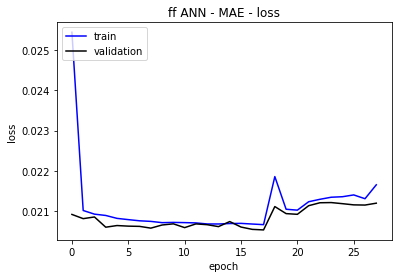

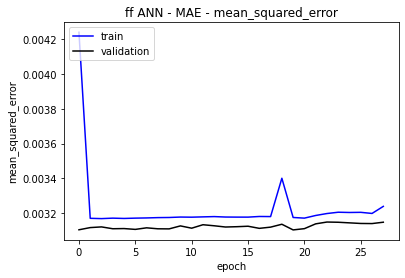

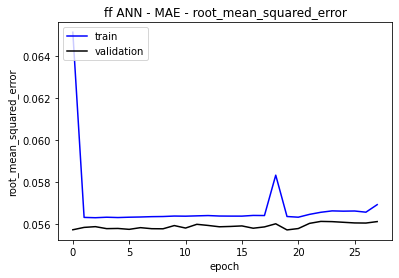

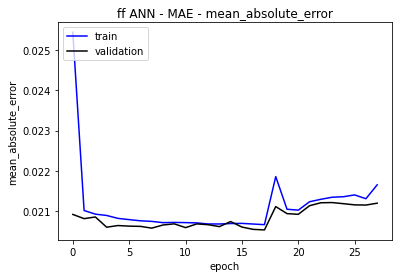

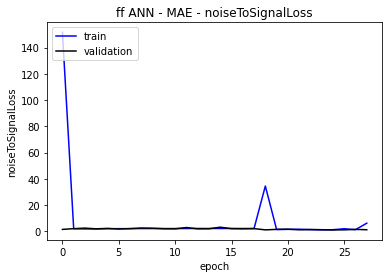

In [ ]:
plot_all(history_mae, 'ff ANN - MAE')

Training without EarlyStopping:

502133/502133 [==============================] - 1492s 3ms/step - loss: 0.0182 - mean_squared_error: 0.0021 - root_mean_squared_error: 0.0455 - mean_absolute_error: 0.0182 - noiseToSignalLoss: 1.1273
dict_keys(['loss', 'mean_squared_error', 'root_mean_squared_error', 'mean_absolute_error', 'noiseToSignalLoss', 'val_loss', 'val_mean_squared_error', 'val_root_mean_squared_error', 'val_mean_absolute_error', 'val_noiseToSignalLoss'])


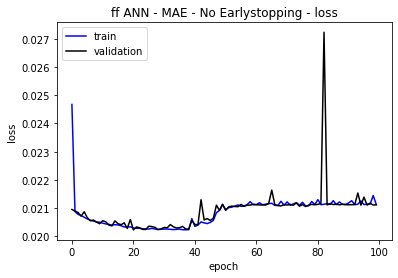

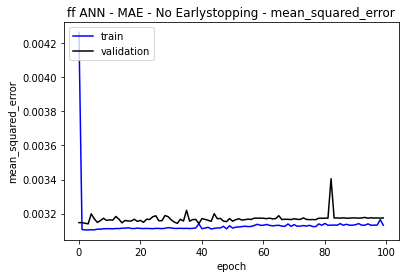

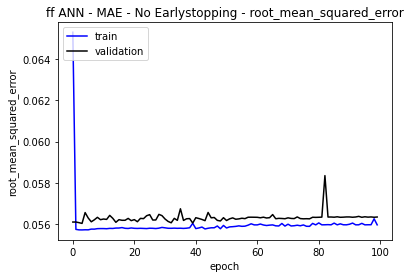

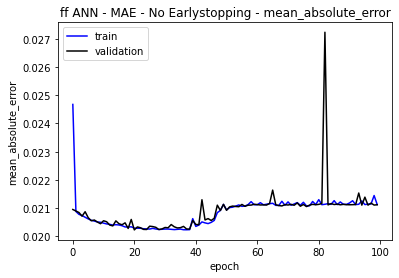

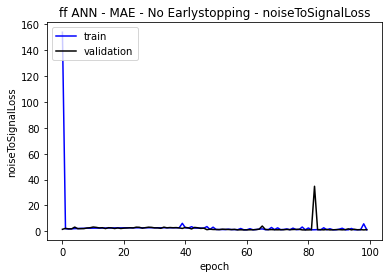

In [ ]:
model_mae_ne.evaluate(test_X, test_Y, batch_size=1)
plot_all(history_mae_ne, 'ff ANN - MAE - No Earlystopping')

In [ ]:
os.chdir('/content/drive/MyDrive/BA')
!mkdir savedModel

model_mae.save('savedModel/ff_ann_mae')

tfjs.converters.convert_tf_saved_model('./savedModel/ff_ann_mae', './savedModel/tfjs_ff_ann_mae')

mkdir: cannot create directory ‘savedModel’: File exists
INFO:tensorflow:Assets written to: savedModel/ff_ann_mae/assets
Writing weight file ./savedModel/tfjs_ff_ann_mae/model.json...


## Optimize MAE with additional Scaling (failed attempt)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
class MinMaxScaler3D():

    def __init__(self, min, max):
      self.min_values = []
      self.max_values = []
      self.min = min
      self.max = max

    def fit(self, X):
      for i in range(X.shape[2]):
        cmin = np.min(X[:, :, i].reshape(X.shape[0] * X.shape[1]))
        cmax = np.max(X[:, :, i].reshape(X.shape[0] * X.shape[1]))
        self.min_values.append(cmin)
        self.max_values.append(cmax)


    def transform(self, X):
      for i in range(X.shape[2]):
        x_scaled = copy.deepcopy(X)
        Xs = X[:, :, i].reshape((X.shape[0] * X.shape[1]))
        X_std = np.subtract(Xs, self.min_values[i]) / (self.max_values[i] - self.min_values[i])
        x_scaled[:, :, i] = (X_std * (self.max_values[i] - self.min_values[i]) + self.max_values[i]).reshape((X.shape[0], X.shape[1]))
        return x_scaled

In [ ]:
scaler = MinMaxScaler((-1, 1))

In [ ]:
train_samples, train_labels, test_samples, test_labels = get_preprocessed_data(5)

In [ ]:
train_samples[:10]

array([[[ 1.00000000e+00,  8.05270864e-03,  0.00000000e+00,
          5.81991215e-02,  9.41800878e-01,  8.83601757e-01,
          4.42708333e-02,  3.84114583e-02,  5.85937500e-03],
        [ 1.00000000e+00, -0.00000000e+00,  0.00000000e+00,
          5.81991215e-02,  9.41800878e-01,  8.83601757e-01,
          4.42708333e-02,  3.84114583e-02,  5.85937500e-03],
        [ 1.00000000e+00,  5.85651537e-03,  0.00000000e+00,
          5.81991215e-02,  9.41800878e-01,  8.83601757e-01,
          4.42708333e-02,  3.84114583e-02,  5.85937500e-03],
        [ 1.00000000e+00, -0.00000000e+00,  0.00000000e+00,
          5.81991215e-02,  9.41800878e-01,  8.83601757e-01,
          4.42708333e-02,  3.84114583e-02,  5.85937500e-03],
        [ 1.00000000e+00,  8.05270864e-03,  0.00000000e+00,
          5.81991215e-02,  9.41800878e-01,  8.83601757e-01,
          4.42708333e-02,  3.84114583e-02,  5.85937500e-03]],

       [[ 0.00000000e+00,  5.46875000e-03,  9.25925926e-04,
          4.41015625e-01,  5.5898

In [ ]:
scaler.fit(train_samples)

In [ ]:
scaler.min_values

[0.0,
 -0.99921875,
 -1.03125,
 -0.271484375,
 0.21796875,
 0.11796875,
 0.018459069020866775,
 -1.1907552083333333,
 -1.287109375]

In [ ]:
train_transformed_maybe = scaler.transform(train_samples)

In [ ]:
train_transformed_maybe

array([[[ 2.00000000e+00,  8.05270864e-03,  0.00000000e+00, ...,
          4.42708333e-02,  3.84114583e-02,  5.85937500e-03],
        [ 2.00000000e+00, -0.00000000e+00,  0.00000000e+00, ...,
          4.42708333e-02,  3.84114583e-02,  5.85937500e-03],
        [ 2.00000000e+00,  5.85651537e-03,  0.00000000e+00, ...,
          4.42708333e-02,  3.84114583e-02,  5.85937500e-03],
        [ 2.00000000e+00, -0.00000000e+00,  0.00000000e+00, ...,
          4.42708333e-02,  3.84114583e-02,  5.85937500e-03],
        [ 2.00000000e+00,  8.05270864e-03,  0.00000000e+00, ...,
          4.42708333e-02,  3.84114583e-02,  5.85937500e-03]],

       [[ 1.00000000e+00,  5.46875000e-03,  9.25925926e-04, ...,
          6.29629630e-02,  3.14814815e-02,  3.14814815e-02],
        [ 1.00000000e+00,  5.85937500e-03,  0.00000000e+00, ...,
          6.29629630e-02,  3.14814815e-02,  3.14814815e-02],
        [ 1.00000000e+00,  5.46875000e-03,  9.25925926e-04, ...,
          6.29629630e-02,  3.24074074e-02,  3.05555

In [ ]:
train_samples.shape

(1704652, 5, 9)

In [ ]:
train_samples[:, :, 0].shape

(1704652, 5)

In [ ]:
test_samples

In [ ]:
def get_improved_data():
    train_samples, train_labels, test_samples, test_labels = get_preprocessed_data(5)

    # train_samples = scaler.fit_transform(train_samples)
    # print(test_samples.shape)
    # test_samples = scaler.transform(test_samples)


    train_samples = train_samples.reshape(train_samples.shape[0], train_samples.shape[1] * train_samples.shape[2])
    test_samples = test_samples.reshape(test_samples.shape[0], test_samples.shape[1] * test_samples.shape[2])

    return train_samples, train_labels, test_samples, test_labels

In [ ]:
train_X, train_Y, test_X, test_Y = get_data()

In [ ]:
# train_X = scaler.fit_transform(train_X)
# test_X = scaler.transform(test_X)

In [ ]:
scaler.scale_

array([ 2.        ,  0.69844383,  0.55371305,  0.98234843,  0.88750217,
        1.88547229, 15.6650516 ,  0.77497477,  0.77497477,  2.        ,
        0.6990721 ,  0.55371305,  0.98234843,  0.88750217,  1.88547229,
       15.6650516 ,  0.77497477,  0.77497477,  2.        ,  0.64434983,
        0.55371305,  0.98234843,  0.88750217,  1.88547229, 15.6650516 ,
        0.77497477,  0.77497477,  2.        ,  0.64434983,  0.55371305,
        0.98234843,  0.88750217,  1.88547229, 15.6650516 ,  0.77497477,
        0.77497477,  2.        ,  0.7134666 ,  0.58270106,  0.98234843,
        0.88750217,  1.88547229, 15.6650516 ,  0.98021698,  1.0204285 ])

In [ ]:
train_X[10]

array([ 1.        , -0.46949309, -0.42898342, -0.67613594, -0.35759742,
        0.44357982, -0.12652172, -0.04641776,  0.02421796,  1.        ,
       -0.47030319, -0.42898342, -0.67613594, -0.35759742,  0.44357982,
       -0.12652172, -0.04641776,  0.02421796,  1.        , -0.35521015,
       -0.42898342, -0.67613594, -0.35759742,  0.44357982, -0.12652172,
       -0.04641776,  0.02421796,  1.        , -0.35473845, -0.42898342,
       -0.67613594, -0.35759742,  0.44357982, -0.12652172, -0.04641776,
        0.02421796,  1.        , -0.49848878, -0.50379363, -0.67613594,
       -0.35759742,  0.44357982, -0.12652172, -0.32354818,  0.34861319])

In [ ]:
train_X[10]

array([1.00000000e+00, 7.32064422e-04, 0.00000000e+00, 5.81991215e-02,
       9.41800878e-01, 8.83601757e-01, 7.42187500e-02, 3.97135417e-02,
       3.45052083e-02, 1.00000000e+00, 1.46412884e-03, 0.00000000e+00,
       5.81991215e-02, 9.41800878e-01, 8.83601757e-01, 7.42187500e-02,
       3.97135417e-02, 3.45052083e-02, 1.00000000e+00, 1.46412884e-03,
       0.00000000e+00, 5.81991215e-02, 9.41800878e-01, 8.83601757e-01,
       7.42187500e-02, 3.97135417e-02, 3.45052083e-02, 1.00000000e+00,
       2.19619327e-03, 0.00000000e+00, 5.81991215e-02, 9.41800878e-01,
       8.83601757e-01, 7.42187500e-02, 3.97135417e-02, 3.45052083e-02,
       1.00000000e+00, 4.39238653e-03, 0.00000000e+00, 5.81991215e-02,
       9.41800878e-01, 8.83601757e-01, 7.42187500e-02, 3.97135417e-02,
       3.45052083e-02])

In [ ]:
def get_model_relu(train_x):
    number_of_inputs = train_x.shape[1]

    model = keras.Sequential()
    model.add(
        layers.Input(shape=(number_of_inputs, ))
    )

    for _ in range(17):
        model.add(
            layers.Dense(154, activation='tanh')
        )

    model.add(
        layers.Dropout(0.2296)
    )

    model.add(
        layers.Dense(2, activation='linear')
    )

    return model

In [ ]:
model_mae = get_model_relu(train_X)

callbacks = [
    keras.callbacks.EarlyStopping(patience=7),
]

metrics = [
    keras.metrics.MeanSquaredError(),
    keras.metrics.RootMeanSquaredError(),
    keras.metrics.MeanAbsoluteError(),
    noiseToSignalLoss,
]

model_mae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.000005), loss=keras.losses.MeanAbsoluteError(), metrics=metrics)

history_mae = model_mae.fit(train_X, train_Y, batch_size=382, validation_split=0.1, verbose=1, epochs=EPOCHS, callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
4017/4017 [==============================] - 35s 8ms/step - loss: 0.0164 - mean_squared_error: 0.0022 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0164 - noiseToSignalLoss: 37.4243 - val_loss: 0.0138 - val_mean_squared_error: 0.0019 - val_root_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.0138 - val_noiseToSignalLoss: 19.7662
Epoch 2/100
4017/4017 [==============================] - 27s 7ms/step - loss: 0.0137 - mean_squared_error: 0.0019 - root_mean_squared_error: 0.0434 - mean_absolute_error: 0.0137 - noiseToSignalLoss: 16.6873 - val_loss: 0.0131 - val_mean_squared_error: 0.0017 - val_root_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.0131 - val_noiseToSignalLoss: 16.6316
Epoch 3/100
4017/4017 [==============================] - 27s 7ms/step - loss: 0.0133 - mean_squared_error: 0.0018 - root_mean_squared_error: 0.0423 - mean_absolute_error: 0.0133 - noiseToSignalLoss: 14.4273 - val_loss: 0.0130 - val_mean_squared_error: 0.0017 - val_root_me

In [ ]:
os.chdir('/content/drive/MyDrive/BA')
!mkdir savedModel

model_mae.save('savedModel/ff_ann_mae_low_lr')

tfjs.converters.convert_tf_saved_model('./savedModel/ff_ann_mae_low_lr', './savedModel/tfjs_ff_ann_mae_low_lr')

mkdir: cannot create directory ‘savedModel’: File exists
INFO:tensorflow:Assets written to: savedModel/ff_ann_mae_low_lr/assets
Writing weight file ./savedModel/tfjs_ff_ann_mae_low_lr/model.json...


In [ ]:
preds = model_mae.predict(test_X[:1000], batch_size=1)

preds

array([[ 1.0914758e-02,  1.2622190e-03],
       [ 7.8558335e-03,  9.6644231e-05],
       [ 1.6115468e-02, -7.9352921e-04],
       ...,
       [ 5.9378315e-03,  2.1977902e-03],
       [ 5.9598191e-03,  7.9279998e-05],
       [ 2.6446687e-02, -1.7227201e-03]], dtype=float32)

In [ ]:
preds = pd.DataFrame(preds, columns=["x", "y"])

In [ ]:
preds

,x,y
0,0.014762,-0.000111
1,0.014762,-0.000111
2,0.014762,-0.000111
3,0.014762,-0.000111
4,0.014762,-0.000111
...,...,...
995,0.014762,-0.000111
996,0.014762,-0.000111
997,0.014762,-0.000111
998,0.014762,-0.000111


In [ ]:
actual = pd.DataFrame(test_Y[:1000], columns=["x", "y"])

In [ ]:
actual

,x,y
0,0.011713,0.001302
1,0.006589,0.000000
2,0.024890,-0.006510
3,0.008785,0.000000
4,0.087500,-0.002222
...,...,...
995,0.011713,0.000000
996,0.004392,0.000000
997,0.007321,0.000000
998,0.005556,0.002222


In [ ]:
scaler.scale_

array([ 2.        ,  0.69844383,  0.55371305,  0.98234843,  0.88750217,
        1.88547229, 15.6650516 ,  0.77497477,  0.77497477,  2.        ,
        0.6990721 ,  0.55371305,  0.98234843,  0.88750217,  1.88547229,
       15.6650516 ,  0.77497477,  0.77497477,  2.        ,  0.64434983,
        0.55371305,  0.98234843,  0.88750217,  1.88547229, 15.6650516 ,
        0.77497477,  0.77497477,  2.        ,  0.64434983,  0.55371305,
        0.98234843,  0.88750217,  1.88547229, 15.6650516 ,  0.77497477,
        0.77497477,  2.        ,  0.7134666 ,  0.58270106,  0.98234843,
        0.88750217,  1.88547229, 15.6650516 ,  0.98021698,  1.0204285 ])

In [ ]:
preds_unique = preds[preds["x"] != preds["x"][0]]
preds_unique

,x,y
26,0.015515,-0.000036
35,0.015515,-0.000036
82,0.015515,-0.000036
86,0.015515,-0.000036
186,0.015515,-0.000036
343,0.015515,-0.000036
444,0.015515,-0.000036
473,0.015515,-0.000036
477,0.015515,-0.000036
626,0.015515,-0.000036


In [ ]:
model_mae.evaluate(test_X, test_Y)

15864/15864 [==============================] - 46s 3ms/step - loss: 0.0152 - mean_squared_error: 0.0018 - root_mean_squared_error: 0.0422 - mean_absolute_error: 0.0152 - noiseToSignalLoss: 10.8117


[0.015244951471686363,
 0.0017769023543223739,
 0.04215331748127937,
 0.015244951471686363,
 10.811695098876953]

In [ ]:
os.chdir('/content/drive/MyDrive/BA')
!mkdir savedModel

model_mae.save('savedModel/ff_ann_mae_2')

tfjs.converters.convert_tf_saved_model('./savedModel/ff_ann_mae_2', './savedModel/tfjs_ff_ann_mae_2')

mkdir: cannot create directory ‘savedModel’: File exists
INFO:tensorflow:Assets written to: savedModel/ff_ann_mae_2/assets
Writing weight file ./savedModel/tfjs_ff_ann_mae_2/model.json...


## Optimize MSE

In [ ]:
model_mse = get_model(train_X)

callbacks = [
    keras.callbacks.EarlyStopping(patience=7),
]

metrics = [
    keras.metrics.MeanSquaredError(),
    keras.metrics.RootMeanSquaredError(),
    keras.metrics.MeanAbsoluteError(),
    noiseToSignalLoss,
]

model_mse.compile(ptimizer=keras.optimizers.Adam(learning_rate=0.000005), loss=keras.losses.MeanSquaredError(), metrics=metrics)

history_mse = model_mse.fit(train_X, train_Y, batch_size=382, validation_split=0.1, verbose=1, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/100
4017/4017 [==============================] - 19s 5ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - root_mean_squared_error: 0.0671 - mean_absolute_error: 0.0301 - noiseToSignalLoss: 187.6820 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.0222 - val_noiseToSignalLoss: 7.5621
Epoch 2/100
4017/4017 [==============================] - 18s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - root_mean_squared_error: 0.0566 - mean_absolute_error: 0.0236 - noiseToSignalLoss: 10.7010 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.0216 - val_noiseToSignalLoss: 1.8517
Epoch 3/100
4017/4017 [==============================] - 18s 4ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - root_mean_squared_error: 0.0563 - mean_absolute_error: 0.0224 - noiseToSignalLoss: 5.4859 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_root_mean

In [ ]:
preds = model_mse.predict(test_X[:1000])

preds

15864/15864 [==============================] - 43s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - root_mean_squared_error: 0.0459 - mean_absolute_error: 0.0188 - noiseToSignalLoss: 1.2725
dict_keys(['loss', 'mean_squared_error', 'root_mean_squared_error', 'mean_absolute_error', 'noiseToSignalLoss', 'val_loss', 'val_mean_squared_error', 'val_root_mean_squared_error', 'val_mean_absolute_error', 'val_noiseToSignalLoss'])


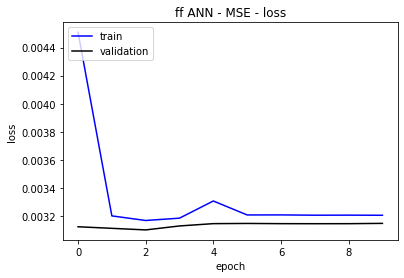

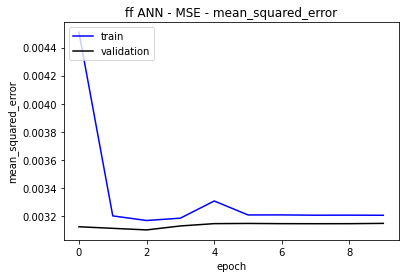

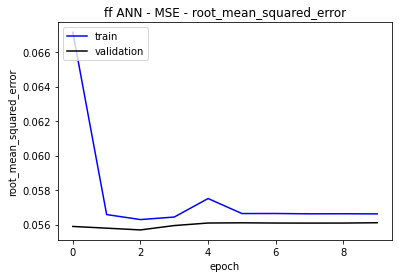

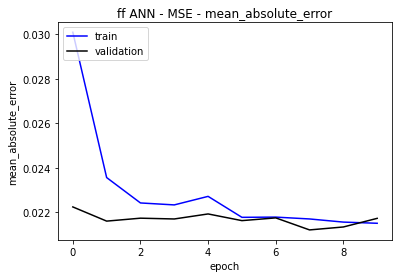

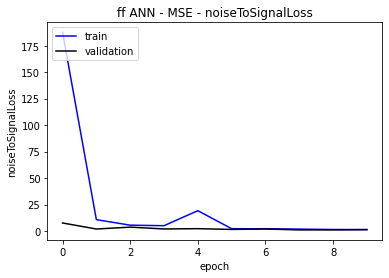

In [ ]:
model_mse.evaluate(test_X, test_Y)
plot_all(history_mse, 'ff ANN - MSE')

Training without EarlyStopping:

502133/502133 [==============================] - 1461s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - root_mean_squared_error: 0.0456 - mean_absolute_error: 0.0185 - noiseToSignalLoss: 2.1299
dict_keys(['loss', 'mean_squared_error', 'root_mean_squared_error', 'mean_absolute_error', 'noiseToSignalLoss', 'val_loss', 'val_mean_squared_error', 'val_root_mean_squared_error', 'val_mean_absolute_error', 'val_noiseToSignalLoss'])


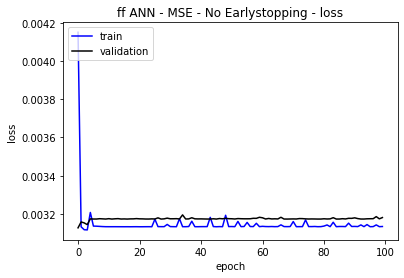

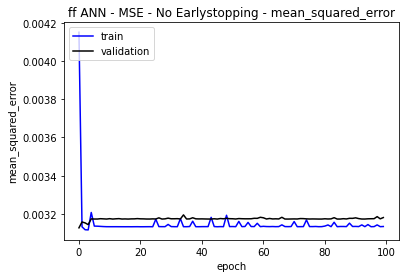

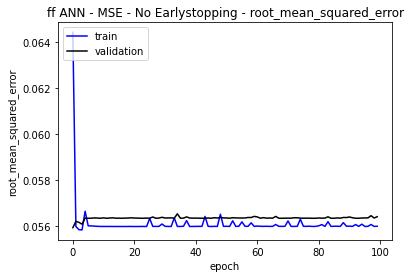

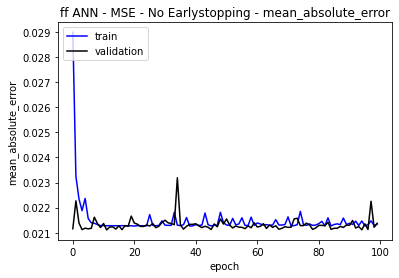

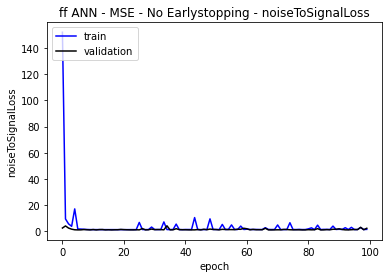

In [ ]:
model_mse_ne.evaluate(test_X, test_Y, batch_size=1)
plot_all(history_mse_ne, 'ff ANN - MSE - No Earlystopping')

In [ ]:
os.chdir('/content/drive/MyDrive/BA')

model_mse.save('savedModel/ff_ann_mse')

tfjs.converters.convert_tf_saved_model('./savedModel/ff_ann_mse', './savedModel/tfjs_ff_ann_mse')

INFO:tensorflow:Assets written to: savedModel/ff_ann_mse/assets
Writing weight file ./savedModel/tfjs_ff_ann_mse/model.json...


## Optimize NTS

In [ ]:
model_nts = get_model(train_X)

callbacks = [
    keras.callbacks.EarlyStopping(patience=7),
]

metrics = [
    keras.metrics.MeanSquaredError(),
    keras.metrics.RootMeanSquaredError(),
    keras.metrics.MeanAbsoluteError(),
    noiseToSignalLoss,
]

model_nts.compile(ptimizer=keras.optimizers.Adam(learning_rate=0.000005), loss=noiseToSignalLoss, metrics=metrics)

history_nts = model_nts.fit(train_X, train_Y, batch_size=382, validation_split=0.1, verbose=1, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/100
4017/4017 [==============================] - 20s 5ms/step - loss: 239.0077 - mean_squared_error: 0.0049 - root_mean_squared_error: 0.0701 - mean_absolute_error: 0.0332 - noiseToSignalLoss: 238.9603 - val_loss: 1.4880 - val_mean_squared_error: 0.0031 - val_root_mean_squared_error: 0.0561 - val_mean_absolute_error: 0.0219 - val_noiseToSignalLoss: 1.4879
Epoch 2/100
4017/4017 [==============================] - 19s 5ms/step - loss: 372.9023 - mean_squared_error: 0.0059 - root_mean_squared_error: 0.0768 - mean_absolute_error: 0.0270 - noiseToSignalLoss: 372.9766 - val_loss: 110.0764 - val_mean_squared_error: 0.0039 - val_root_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.0384 - val_noiseToSignalLoss: 110.0445
Epoch 3/100
4017/4017 [==============================] - 19s 5ms/step - loss: 27.9167 - mean_squared_error: 0.0034 - root_mean_squared_error: 0.0582 - mean_absolute_error: 0.0251 - noiseToSignalLoss: 27.9114 - val_loss: 1.2944 - val_mean_squared_error: 0.0031 - va

In [ ]:
preds = model_nts.predict(test_X[:1000])

preds

15864/15864 [==============================] - 45s 3ms/step - loss: 1.4072 - mean_squared_error: 0.0021 - root_mean_squared_error: 0.0459 - mean_absolute_error: 0.0190 - noiseToSignalLoss: 1.4072
dict_keys(['loss', 'mean_squared_error', 'root_mean_squared_error', 'mean_absolute_error', 'noiseToSignalLoss', 'val_loss', 'val_mean_squared_error', 'val_root_mean_squared_error', 'val_mean_absolute_error', 'val_noiseToSignalLoss'])


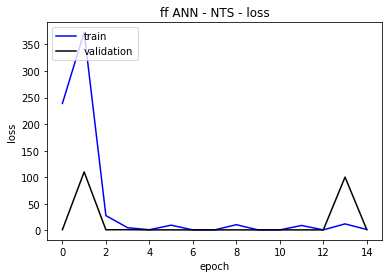

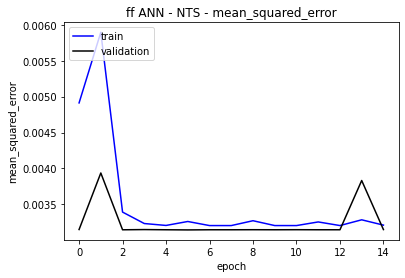

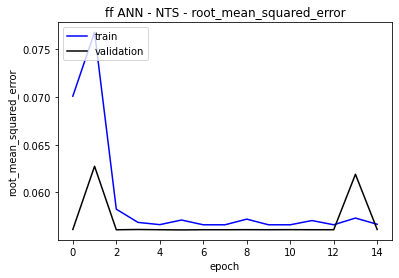

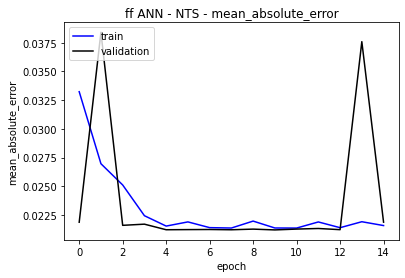

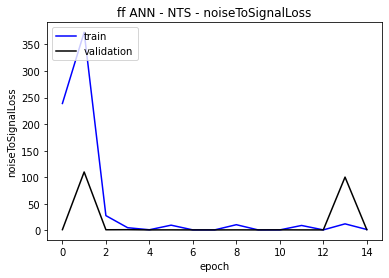

In [ ]:
model_nts.evaluate(test_X, test_Y)
plot_all(history_nts, 'ff ANN - NTS')

Training without EarlyStopping:

502133/502133 [==============================] - 1469s 3ms/step - loss: 1.2914 - mean_squared_error: 0.0021 - root_mean_squared_error: 0.0455 - mean_absolute_error: 0.0188 - noiseToSignalLoss: 1.2914
dict_keys(['loss', 'mean_squared_error', 'root_mean_squared_error', 'mean_absolute_error', 'noiseToSignalLoss', 'val_loss', 'val_mean_squared_error', 'val_root_mean_squared_error', 'val_mean_absolute_error', 'val_noiseToSignalLoss'])


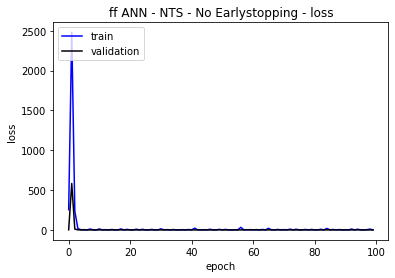

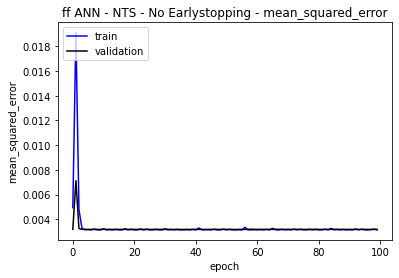

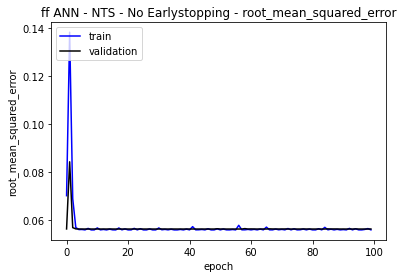

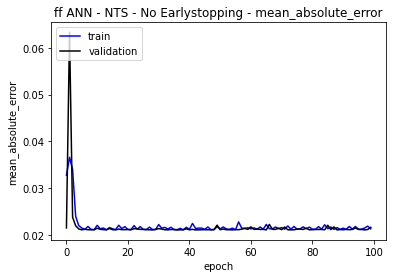

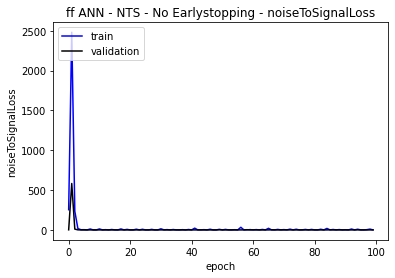

In [ ]:
model_nts_ne.evaluate(test_X, test_Y, batch_size=1)
plot_all(history_nts_ne, 'ff ANN - NTS - No Earlystopping')

In [ ]:
os.chdir('/content/drive/MyDrive/BA')

model_mse.save('savedModel/ff_ann_nts')

tfjs.converters.convert_tf_saved_model('./savedModel/ff_ann_nts', './savedModel/tfjs_ff_ann_nts')

INFO:tensorflow:Assets written to: savedModel/ff_ann_nts/assets
Writing weight file ./savedModel/tfjs_ff_ann_nts/model.json...


# RNN

In [ ]:
def get_recurrent_data():
    train_samples, train_labels, test_samples, test_labels = get_preprocessed_data(7)

    return train_samples, train_labels, test_samples, test_labels

In [ ]:
def get_rnn_model(train_x):
    number_of_inputs = train_x.shape[1]

    model = keras.Sequential()
    model.add(
        layers.Input(shape=(number_of_inputs, 9, ))
    )
    model.add(
        layers.SimpleRNN(191, activation='sigmoid', return_sequences=False)
    )

    model.add(
        layers.Dropout(0.07967)
    )

    model.add(
        layers.Dense(2, activation='linear')
    )

    return model

In [ ]:
os.chdir('/content/drive/MyDrive/BA/data')
train_X, train_Y, test_X, test_Y = get_recurrent_data()

[5.12720995e-01 5.92416624e-03 1.67140702e-05 1.98421607e-01
 8.09774842e-01 6.11353235e-01 5.82557838e-02 2.29240444e-02
 3.53317394e-02]


## Optimize MAE

In [ ]:
rnn_model_mae = get_rnn_model(train_X)
# rnn_model_mae.summary()

callbacks = [
    keras.callbacks.EarlyStopping(patience=7),
]

metrics = [
    keras.metrics.MeanSquaredError(),
    keras.metrics.RootMeanSquaredError(),
    keras.metrics.MeanAbsoluteError(),
    noiseToSignalLoss,
]

rnn_model_mae.compile(optimizer=tf.keras.optimizers.SGD(), loss=keras.losses.MeanAbsoluteError(), metrics=metrics)

history_rnn_mae = rnn_model_mae.fit(train_X, train_Y, batch_size=138, validation_split=0.1, verbose=1, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/100
11329/11329 [==============================] - 88s 8ms/step - loss: 0.0808 - mean_squared_error: 0.0110 - root_mean_squared_error: 0.1047 - mean_absolute_error: 0.0808 - noiseToSignalLoss: 1199.1305 - val_loss: 0.0637 - val_mean_squared_error: 0.0063 - val_root_mean_squared_error: 0.0797 - val_mean_absolute_error: 0.0637 - val_noiseToSignalLoss: 495.1051
Epoch 2/100
11329/11329 [==============================] - 87s 8ms/step - loss: 0.0541 - mean_squared_error: 0.0054 - root_mean_squared_error: 0.0733 - mean_absolute_error: 0.0541 - noiseToSignalLoss: 348.5231 - val_loss: 0.0421 - val_mean_squared_error: 0.0042 - val_root_mean_squared_error: 0.0648 - val_mean_absolute_error: 0.0421 - val_noiseToSignalLoss: 159.5219
Epoch 3/100
11329/11329 [==============================] - 90s 8ms/step - loss: 0.0457 - mean_squared_error: 0.0045 - root_mean_squared_error: 0.0671 - mean_absolute_error: 0.0457 - noiseToSignalLoss: 213.7642 - val_loss: 0.0364 - val_mean_squared_error: 0.0038 -

16161/16161 [==============================] - 48s 3ms/step - loss: 0.0233 - mean_squared_error: 0.0022 - root_mean_squared_error: 0.0468 - mean_absolute_error: 0.0233 - noiseToSignalLoss: 14.7014
dict_keys(['loss', 'mean_squared_error', 'root_mean_squared_error', 'mean_absolute_error', 'noiseToSignalLoss', 'val_loss', 'val_mean_squared_error', 'val_root_mean_squared_error', 'val_mean_absolute_error', 'val_noiseToSignalLoss'])


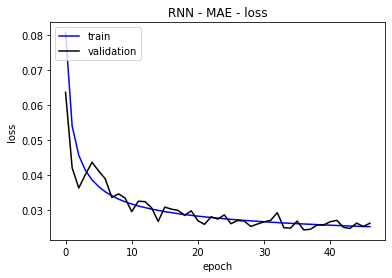

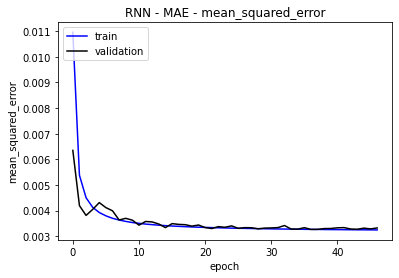

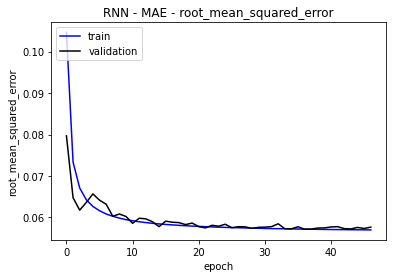

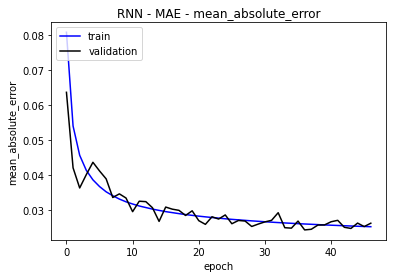

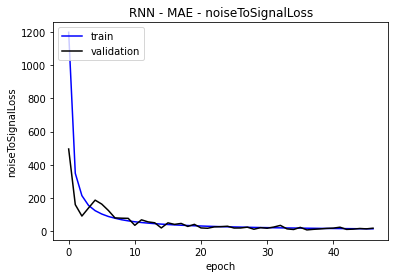

In [ ]:
rnn_model_mae.evaluate(test_X, test_Y)
plot_all(history_rnn_mae, 'RNN - MAE')

In [ ]:
os.chdir('/content/drive/MyDrive/BA')

rnn_model_mae.save('savedModel/rnn_mae')

tfjs.converters.convert_tf_saved_model('./savedModel/rnn_mae', './savedModel/tfjs_rnn_mae', control_flow_v2=True)

INFO:tensorflow:Assets written to: savedModel/rnn_mae/assets
Writing weight file ./savedModel/tfjs_rnn_mae/model.json...


## Optimize MSE

In [ ]:
rnn_model_mse = get_rnn_model(train_X)

callbacks = [
    keras.callbacks.EarlyStopping(patience=7),
]

metrics = [
    keras.metrics.MeanSquaredError(),
    keras.metrics.RootMeanSquaredError(),
    keras.metrics.MeanAbsoluteError(),
    noiseToSignalLoss,
]

rnn_model_mse.compile(optimizer='sgd', loss=keras.losses.MeanSquaredError(), metrics=metrics)

history_rnn_mse = rnn_model_mse.fit(train_X, train_Y, batch_size=138, validation_split=0.1, verbose=1, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/100
11329/11329 [==============================] - 87s 8ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - root_mean_squared_error: 0.1060 - mean_absolute_error: 0.0698 - noiseToSignalLoss: 1214.5902 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_root_mean_squared_error: 0.0571 - val_mean_absolute_error: 0.0228 - val_noiseToSignalLoss: 7.4847
Epoch 2/100
11329/11329 [==============================] - 89s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - root_mean_squared_error: 0.0594 - mean_absolute_error: 0.0294 - noiseToSignalLoss: 56.9814 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_root_mean_squared_error: 0.0568 - val_mean_absolute_error: 0.0219 - val_noiseToSignalLoss: 3.2364
Epoch 3/100
11329/11329 [==============================] - 86s 8ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - root_mean_squared_error: 0.0571 - mean_absolute_error: 0.0246 - noiseToSignalLoss: 16.4466 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_r

16161/16161 [==============================] - 47s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - root_mean_squared_error: 0.0457 - mean_absolute_error: 0.0184 - noiseToSignalLoss: 1.7129
dict_keys(['loss', 'mean_squared_error', 'root_mean_squared_error', 'mean_absolute_error', 'noiseToSignalLoss', 'val_loss', 'val_mean_squared_error', 'val_root_mean_squared_error', 'val_mean_absolute_error', 'val_noiseToSignalLoss'])


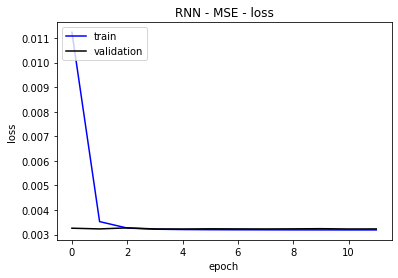

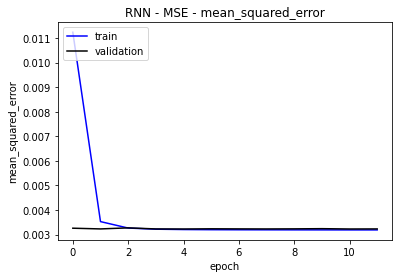

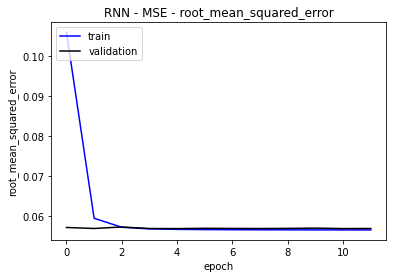

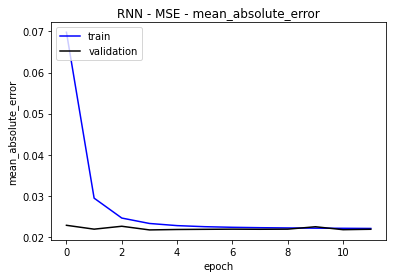

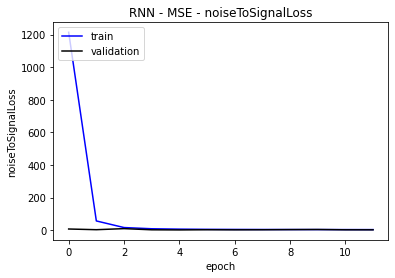

In [ ]:
rnn_model_mse.evaluate(test_X, test_Y)
plot_all(history_rnn_mse, 'RNN - MSE')

In [ ]:
os.chdir('/content/drive/MyDrive/BA')

rnn_model_mse.save('savedModel/rnn_mse')

tfjs.converters.convert_tf_saved_model('./savedModel/rnn_mse', './savedModel/tfjs_rnn_mse', control_flow_v2=True)

INFO:tensorflow:Assets written to: savedModel/rnn_mse/assets
Writing weight file ./savedModel/tfjs_rnn_mse/model.json...


## Optimize NTS

In [ ]:
def get_rnn_nts_model(train_x):
    number_of_inputs = train_x.shape[1]

    model = keras.Sequential()
    model.add(
        layers.Input(shape=(number_of_inputs, 9, ))
    )
    model.add(
        layers.SimpleRNN(191, activation='sigmoid', return_sequences=False)
    )

    model.add(
        layers.Dropout(0.07967)
    )

    model.add(
        layers.Dense(2, activation='linear')
    )

    return model

In [ ]:
rnn_model_nts = get_rnn_nts_model(train_X)

callbacks = [
    keras.callbacks.EarlyStopping(patience=7),
]

metrics = [
    keras.metrics.MeanSquaredError(),
    keras.metrics.RootMeanSquaredError(),
    keras.metrics.MeanAbsoluteError(),
    noiseToSignalLoss,
]

rnn_model_nts.compile(optimizer=keras.optimizers.SGD(clipvalue=0.5), loss=noiseToSignalLoss, metrics=metrics)

history_rnn_nts = rnn_model_nts.fit(train_X, train_Y, batch_size=138, validation_split=0.1, verbose=1, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/100
11329/11329 [==============================] - 92s 8ms/step - loss: 6032.9507 - mean_squared_error: 0.0426 - root_mean_squared_error: 0.2063 - mean_absolute_error: 0.0816 - noiseToSignalLoss: 6032.6313 - val_loss: 4.4758 - val_mean_squared_error: 0.0033 - val_root_mean_squared_error: 0.0572 - val_mean_absolute_error: 0.0231 - val_noiseToSignalLoss: 4.4756
Epoch 2/100
11329/11329 [==============================] - 88s 8ms/step - loss: 91.2134 - mean_squared_error: 0.0042 - root_mean_squared_error: 0.0651 - mean_absolute_error: 0.0269 - noiseToSignalLoss: 91.2141 - val_loss: 158.4900 - val_mean_squared_error: 0.0063 - val_root_mean_squared_error: 0.0793 - val_mean_absolute_error: 0.0300 - val_noiseToSignalLoss: 158.4639
Epoch 3/100
11329/11329 [==============================] - 90s 8ms/step - loss: 104.7999 - mean_squared_error: 0.0046 - root_mean_squared_error: 0.0680 - mean_absolute_error: 0.0306 - noiseToSignalLoss: 104.8088 - val_loss: 30.8397 - val_mean_squared_error: 0.

16161/16161 [==============================] - 48s 3ms/step - loss: 1.9516 - mean_squared_error: 0.0021 - root_mean_squared_error: 0.0459 - mean_absolute_error: 0.0189 - noiseToSignalLoss: 1.9516
dict_keys(['loss', 'mean_squared_error', 'root_mean_squared_error', 'mean_absolute_error', 'noiseToSignalLoss', 'val_loss', 'val_mean_squared_error', 'val_root_mean_squared_error', 'val_mean_absolute_error', 'val_noiseToSignalLoss'])


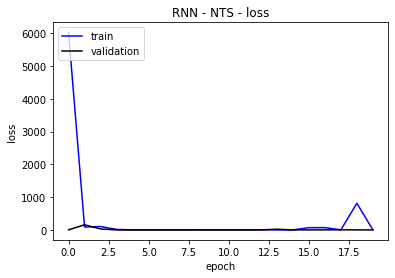

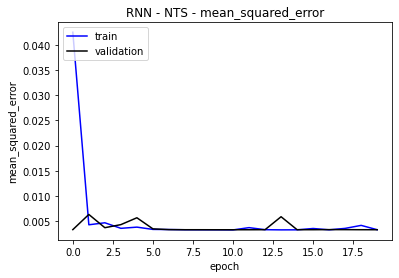

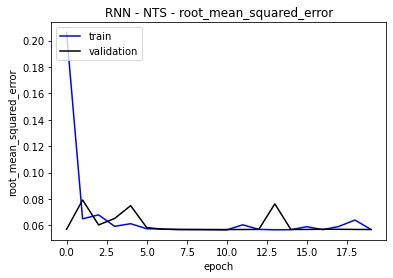

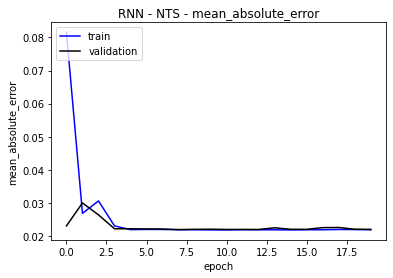

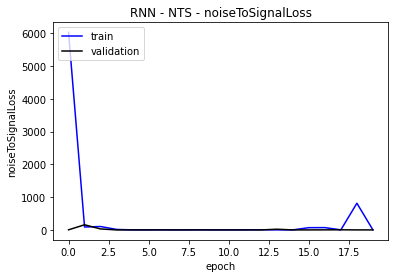

In [ ]:
rnn_model_nts.evaluate(test_X, test_Y)
plot_all(history_rnn_nts, 'RNN - NTS')

In [ ]:
os.chdir('/content/drive/MyDrive/BA')

rnn_model_nts.save('savedModel/rnn_nts')

tfjs.converters.convert_tf_saved_model('./savedModel/rnn_nts', './savedModel/tfjs_rnn_nts', control_flow_v2=True)

INFO:tensorflow:Assets written to: savedModel/rnn_nts/assets
Writing weight file ./savedModel/tfjs_rnn_nts/model.json...


# Transformer

In [ ]:
# get implementation
%%capture

!pip install wget
import wget
os.chdir('/content/drive/MyDrive/BA/')
wget.download('https://raw.githubusercontent.com/ragor114/Prediction-Transformer/main/prediction_transformer.py', 'prediction_transformer.py')

from prediction_transformer import get_model
os.chdir('/content/drive/MyDrive/BA/demographic_data')

In [ ]:
def get_transformer_data():
    train_samples, train_labels, test_samples, test_labels = get_preprocessed_data(13)

    return train_samples, train_labels, test_samples, test_labels

In [ ]:
train_X, train_Y, test_X, test_Y = get_transformer_data()

[5.02146351e-01 5.36367058e-03 1.59450345e-05 1.98348252e-01
 8.09988995e-01 6.11640743e-01 5.82829500e-02 2.28046056e-02
 3.54783443e-02]


## MAE

In [ ]:
model_transformer_mae = get_model([train_X.shape[1], 9], train_X.shape[1], 176, 4, 10, 229, 2, 0.0134, 'sigmoid', 9)

metrics = [
    keras.metrics.MeanSquaredError(),
    keras.metrics.RootMeanSquaredError(),
    keras.metrics.MeanAbsoluteError(),
    noiseToSignalLoss,
]

model_transformer_mae.compile('adagrad', loss=keras.losses.MeanAbsoluteError(), metrics=metrics)

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=7),
]

history_trans_mae = model_transformer_mae.fit(train_X, train_Y, batch_size=35, validation_split=0.1, verbose=1, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/100
45990/45990 [==============================] - 2221s 48ms/step - loss: 0.0220 - mean_squared_error: 0.0032 - root_mean_squared_error: 0.0568 - mean_absolute_error: 0.0220 - noiseToSignalLoss: 6.9002 - val_loss: 0.0211 - val_mean_squared_error: 0.0032 - val_root_mean_squared_error: 0.0564 - val_mean_absolute_error: 0.0211 - val_noiseToSignalLoss: 1.1859
Epoch 2/100
45990/45990 [==============================] - 2024s 44ms/step - loss: 0.0210 - mean_squared_error: 0.0032 - root_mean_squared_error: 0.0565 - mean_absolute_error: 0.0210 - noiseToSignalLoss: 1.2210 - val_loss: 0.0210 - val_mean_squared_error: 0.0032 - val_root_mean_squared_error: 0.0563 - val_mean_absolute_error: 0.0210 - val_noiseToSignalLoss: 1.1680
Epoch 3/100
45990/45990 [==============================] - 2070s 45ms/step - loss: 0.0210 - mean_squared_error: 0.0032 - root_mean_squared_error: 0.0564 - mean_absolute_error: 0.0210 - noiseToSignalLoss: 1.2224 - val_loss: 0.0210 - val_mean_squared_error: 0.0032 - v

KeyboardInterrupt: ignored

In [ ]:
model_transformer_mae.evaluate(test_X, test_Y)
plot_all(history_trans_mae, 'Transformer - MAE')

In [ ]:
os.chdir('/content/drive/MyDrive/BA')

model_transformer_mae.save('savedModel/transformer_mae')

tfjs.converters.convert_tf_saved_model('./savedModel/transformer_mae', './savedModel/tfjs_transformer_mae')

## MSE

In [ ]:
model_transformer_mse = get_model([train_X.shape[1], 9], train_X.shape[1], 176, 4, 10, 229, 2, 0.0134, 'sigmoid', 9)

metrics = [
    keras.metrics.MeanSquaredError(),
    keras.metrics.RootMeanSquaredError(),
    keras.metrics.MeanAbsoluteError(),
    noiseToSignalLoss,
]

callbacks = [
    keras.callbacks.EarlyStopping(patience=7),
]

model_transformer_mse.compile('adagrad', loss=keras.losses.MeanSquaredError(), metrics=metrics)
history_trans_mse = model_transformer_mse.fit(train_X, train_Y, batch_size=35, validation_split=0.1, verbose=1, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/100
45990/45990 [==============================] - 1535s 33ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - root_mean_squared_error: 0.0585 - mean_absolute_error: 0.0270 - noiseToSignalLoss: 41.8117 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_root_mean_squared_error: 0.0563 - val_mean_absolute_error: 0.0220 - val_noiseToSignalLoss: 4.3646
Epoch 2/100
45990/45990 [==============================] - 1518s 33ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - root_mean_squared_error: 0.0569 - mean_absolute_error: 0.0238 - noiseToSignalLoss: 13.3785 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_root_mean_squared_error: 0.0562 - val_mean_absolute_error: 0.0218 - val_noiseToSignalLoss: 4.7739
Epoch 3/100
45990/45990 [==============================] - 1515s 33ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - root_mean_squared_error: 0.0567 - mean_absolute_error: 0.0231 - noiseToSignalLoss: 9.6914 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 -

15233/15233 [==============================] - 249s 16ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - root_mean_squared_error: 0.0468 - mean_absolute_error: 0.0184 - noiseToSignalLoss: 3.3657
dict_keys(['loss', 'mean_squared_error', 'root_mean_squared_error', 'mean_absolute_error', 'noiseToSignalLoss', 'val_loss', 'val_mean_squared_error', 'val_root_mean_squared_error', 'val_mean_absolute_error', 'val_noiseToSignalLoss'])


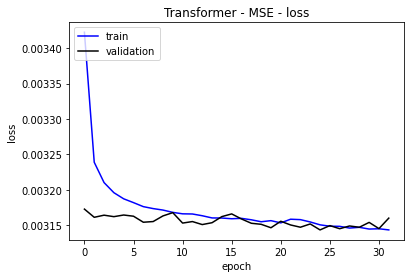

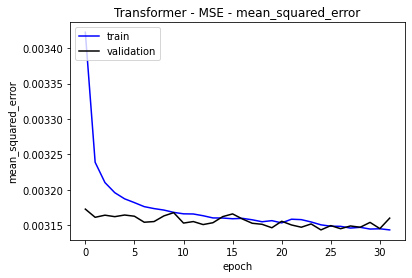

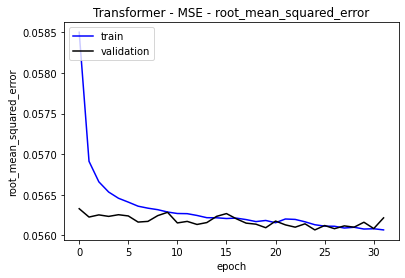

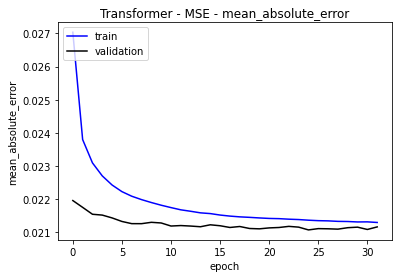

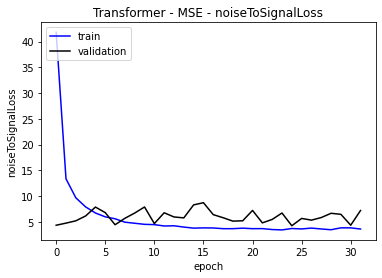

In [ ]:
model_transformer_mse.evaluate(test_X, test_Y)
plot_all(history_trans_mse, 'Transformer - MSE')

In [ ]:
os.chdir('/content/drive/MyDrive/BA')

model_transformer_mse.save('savedModel/transformer_mse')

tfjs.converters.convert_tf_saved_model('./savedModel/transformer_mse', './savedModel/tfjs_transformer_mse')

INFO:tensorflow:Assets written to: savedModel/transformer_mse/assets


INFO:tensorflow:Assets written to: savedModel/transformer_mse/assets


Writing weight file ./savedModel/tfjs_transformer_mse/model.json...


## NTS

In [ ]:
model_transformer_nts = get_model([train_X.shape[1], 9], train_X.shape[1], 176, 4, 10, 229, 2, 0.0134, 'sigmoid', 9)

metrics = [
    keras.metrics.MeanSquaredError(),
    keras.metrics.RootMeanSquaredError(),
    keras.metrics.MeanAbsoluteError(),
    noiseToSignalLoss,
]

callbacks = [
    keras.callbacks.EarlyStopping(patience=7),
]

model_transformer_nts.compile('adagrad', loss=noiseToSignalLoss, metrics=metrics)
history_trans_nts = model_transformer_nts.fit(train_X, train_Y, batch_size=35, validation_split=0.1, verbose=1, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/100
45990/45990 [==============================] - 1606s 35ms/step - loss: 12.0552 - mean_squared_error: 0.0033 - root_mean_squared_error: 0.0572 - mean_absolute_error: 0.0229 - noiseToSignalLoss: 12.0552 - val_loss: 1.0791 - val_mean_squared_error: 0.0032 - val_root_mean_squared_error: 0.0564 - val_mean_absolute_error: 0.0212 - val_noiseToSignalLoss: 1.0791
Epoch 2/100
45990/45990 [==============================] - 1567s 34ms/step - loss: 1.5726 - mean_squared_error: 0.0032 - root_mean_squared_error: 0.0565 - mean_absolute_error: 0.0215 - noiseToSignalLoss: 1.5726 - val_loss: 1.0520 - val_mean_squared_error: 0.0032 - val_root_mean_squared_error: 0.0564 - val_mean_absolute_error: 0.0212 - val_noiseToSignalLoss: 1.0520
Epoch 3/100
45990/45990 [==============================] - 1552s 34ms/step - loss: 1.2695 - mean_squared_error: 0.0032 - root_mean_squared_error: 0.0565 - mean_absolute_error: 0.0213 - noiseToSignalLoss: 1.2695 - val_loss: 1.0235 - val_mean_squared_error: 0.0032 -

16661/16661 [==============================] - 274s 16ms/step - loss: 0.9977 - mean_squared_error: 0.0022 - root_mean_squared_error: 0.0466 - mean_absolute_error: 0.0182 - noiseToSignalLoss: 0.9977
dict_keys(['loss', 'mean_squared_error', 'root_mean_squared_error', 'mean_absolute_error', 'noiseToSignalLoss', 'val_loss', 'val_mean_squared_error', 'val_root_mean_squared_error', 'val_mean_absolute_error', 'val_noiseToSignalLoss'])


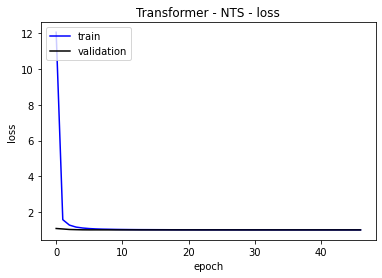

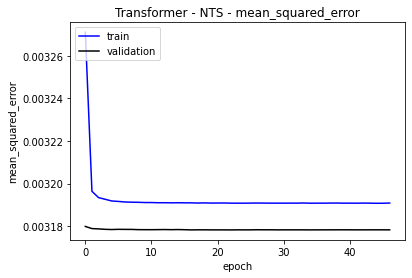

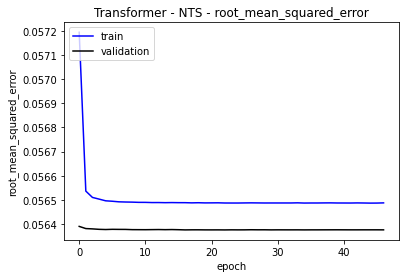

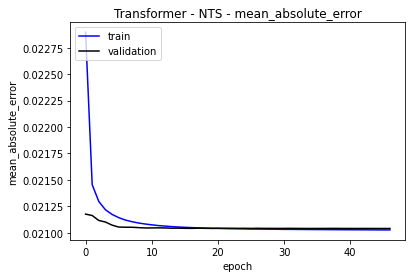

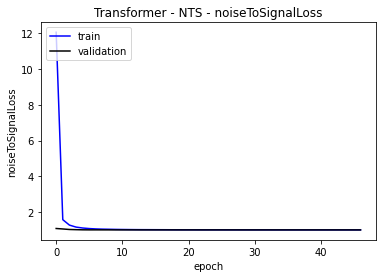

In [ ]:
model_transformer_nts.evaluate(test_X, test_Y)
plot_all(history_trans_nts, 'Transformer - NTS')

In [ ]:
os.chdir('/content/drive/MyDrive/BA')

model_transformer_nts.save('savedModel/transformer_nts')

tfjs.converters.convert_tf_saved_model('./savedModel/transformer_nts', './savedModel/tfjs_transformer_nts')

INFO:tensorflow:Assets written to: savedModel/transformer_nts/assets


INFO:tensorflow:Assets written to: savedModel/transformer_nts/assets


Writing weight file ./savedModel/tfjs_transformer_nts/model.json...
